# Demo of e-valuator

In this notebook, we demonstrate how to use our package to apply to score chess games. We require the user to input a (calibration) dataframe of agent trajectories with the following columns:

* `uq_problem_idx`: A unique identifier for each game. Multiple rows will correspond to the same game, so this is an identifier of the game.
* `num_steps`: Number of moves taken in the game thus far.
* `judge_probability`: Stockfish centipawn score for current position.
* `solved`: A binary indicator (0/1) of whether that White won that game or not. This column is only required during calibration time.

You may use different names for the columns, in which case you'll have to specify in your function arguments the variable names. For instance, you'd have to change the `prob_col`, `problem_col`, and `step_col` arguments of this function:

```
add_judge_probability_series(
    df: pd.DataFrame,
    prob_col: str = "judge_probability",
    problem_col: str = "problem_idx",
    step_col: str = "num_steps",
)
```


Note: see `../demos/collect_chess_example.py` to see how these scores and games were collected.


In [3]:
import pandas as pd
import numpy as np

## import the package
import evaluator as e_val

csv_path = "../../data/chessgames_w_scores_compressed.csv.gz"

In [4]:
## load in the raw data
df = pd.read_csv(csv_path)

print("Loaded:", df.shape)
print(df.columns)



## add a column of concatenated verifier scores
## note: this step takes some time
df = e_val.utils.add_judge_probability_series(df)
df.head()


Loaded: (69023, 7)
Index(['uq_problem_idx', 'move_num', 'winner', 'solved',
       'stockfish_probability', 'judge_probability', 'num_steps'],
      dtype='object')


Building judge_probability_series:   0%|          | 0/69023 [00:00<?, ?it/s]

Building judge_probability_series: 100%|██████████| 69023/69023 [04:41<00:00, 244.79it/s]


,uq_problem_idx,move_num,winner,solved,stockfish_probability,judge_probability,num_steps,judge_probability_series
0,game_16,1,W,True,0.524834,0.524834,1,[0.5248335896523929]
1,game_16,2,W,True,0.588353,0.588353,2,"[0.5248335896523929, 0.5883532029754936]"
2,game_16,3,W,True,0.551367,0.551367,3,"[0.5248335896523929, 0.5883532029754936, 0.551..."
3,game_16,4,W,True,0.664003,0.664003,4,"[0.5248335896523929, 0.5883532029754936, 0.551..."
4,game_16,5,W,True,0.540415,0.540415,5,"[0.5248335896523929, 0.5883532029754936, 0.551..."


Now that we have our dataframe set up, let's split it into calibration and test set. In general, you can load in different dataframes for calibration and test, but in this notebook we generate them as splits of the same set. Note that a single problem must be fully in either test or calibration (e.g., no instances where steps 1-2 are in calibration and 3-4 are in test).

In [5]:
## get list of all unique problem indices
unique_ids = df["uq_problem_idx"].unique()
rng = np.random.default_rng(42)

# 80/20 split of calibration and test set
n_cal = int(0.8 * len(unique_ids))
cal_ids = rng.choice(unique_ids, size=n_cal, replace=False)
test_ids = np.setdiff1d(unique_ids, cal_ids)


## split into calibration and test set
cal_df = df[df["uq_problem_idx"].isin(cal_ids)].reset_index(drop=True)
test_df = df[df["uq_problem_idx"].isin(test_ids)].reset_index(drop=True)

print("Calibration:", cal_df.shape, "Unique problems:", len(cal_ids))
print("Test:", test_df.shape, "Unique problems:", len(test_ids))


Calibration: (55250, 8) Unique problems: 888
Test: (13773, 8) Unique problems: 223


In [6]:
cal_df

,uq_problem_idx,move_num,winner,solved,stockfish_probability,judge_probability,num_steps,judge_probability_series
0,game_52,1,W,True,0.513804,0.513804,1,[0.5138042910293155]
1,game_52,2,W,True,0.574014,0.574014,2,"[0.5138042910293155, 0.5740142874632654]"
2,game_52,3,W,True,0.519321,0.519321,3,"[0.5138042910293155, 0.5740142874632654, 0.519..."
3,game_52,4,W,True,0.580304,0.580304,4,"[0.5138042910293155, 0.5740142874632654, 0.519..."
4,game_52,5,W,True,0.545896,0.545896,5,"[0.5138042910293155, 0.5740142874632654, 0.519..."
...,...,...,...,...,...,...,...,...
55245,game_19972,87,W,True,0.999429,0.999429,87,"[0.5303398401818216, 0.5722126153120402, 0.528..."
55246,game_19972,88,W,True,0.999405,0.999405,88,"[0.5303398401818216, 0.5722126153120402, 0.528..."
55247,game_19972,89,W,True,0.999447,0.999447,89,"[0.5303398401818216, 0.5722126153120402, 0.528..."
55248,game_19972,90,W,True,1.000000,1.000000,90,"[0.5303398401818216, 0.5722126153120402, 0.528..."


Now we'll fit our density ratio estimators. By default, we recommend logistic regression, which can be specified with `model_type="logistic"` as we do below. However, we also support random forests and plan to support other DRE methods in the future. You may also modify `evaluator.py` to change the density ratio estimation procedure (e.g., add L2 penalty to the Logistic Regression).

In [7]:
ev = e_val.EValuator(
    model_type="logistic",   
    mt_variant="both",    ## "split" is finite time/empirical version of e-valuator. "anytime" is the anytime-valid version. "both" adds both the finite-time and empirical versions as columns to the test set.
    alphas=[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5], ## by default, alphas = [0.05] unless otherwise specified, as we do here
    # delta=0.1, ## only used for split version, confidence level in false alarm guarantee. default is 0.1 (meaning 90% confidence in false alarm guarantee)
    delta=0.05,
)

ev


In [8]:
ev.fit(cal_df)


In [9]:
## apply the learned density ratio estimators to the test set
test_df = ev.apply(test_df)

In [10]:
## let's look at at the statistics
## note anytime eval and split eval will be different because split eval splits the calibration set into two parts
test_df[["uq_problem_idx", "num_steps", "solved"] + [c for c in test_df.columns if "e_val" in c]]


,uq_problem_idx,num_steps,solved,anytime_e_val,split_e_val
0,game_16,1,True,1.049328,0.993128
1,game_16,2,True,1.049452,0.994971
2,game_16,3,True,0.901363,0.752232
3,game_16,4,True,0.745761,0.545563
4,game_16,5,True,0.765092,0.552044
...,...,...,...,...,...
13768,game_19990,71,False,0.042447,0.099716
13769,game_19990,72,False,0.053748,0.105839
13770,game_19990,73,False,0.236320,0.469535
13771,game_19990,74,False,0.768571,0.848571


Let's check out what the scores look like on the test set.

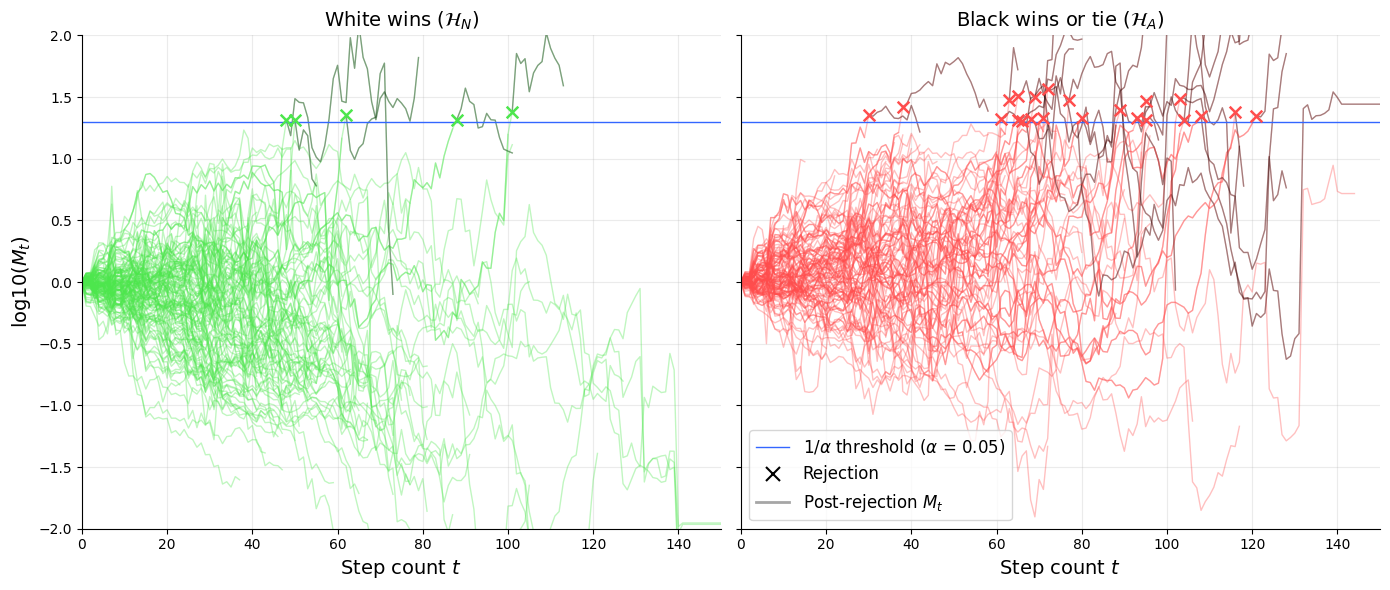

In [16]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

df = test_df.sort_values(["uq_problem_idx", "num_steps"])

# Per-problem solved label
solved_per_problem = df.groupby("uq_problem_idx")["solved"].max()

# Colors
color_0 = (1.0, 0.3, 0.3, 0.35)   # red (Black wins or tie / H_A)
color_1 = (0.3, 0.9, 0.3, 0.35)   # green (White wins / H_N)

color_0_solid = (1.0, 0.3, 0.3, 1.0)
color_1_solid = (0.3, 0.9, 0.3, 1.0)

# Post-rejection
post_rejection_color = (0.0, 0.0, 0.0, 0.35)

# Blue threshold
threshold_color = (0.2, 0.4, 1.0, 1.0)

# Safe log
eps = 1e-6
df["log_any"] = np.log10(df["anytime_e_val"].clip(lower=eps))

threshold = np.log10(20)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for solved_value, ax in zip([1, 0], axes):

    problems = solved_per_problem[solved_per_problem == solved_value].index
    sub_df = df[df["uq_problem_idx"].isin(problems)]
    base_color = color_1 if solved_value == 1 else color_0

    for uqid, grp in sub_df.groupby("uq_problem_idx"):
        grp = grp.sort_values("num_steps")
        x_real = grp["num_steps"].to_numpy()
        y_real = grp["log_any"].to_numpy()

        # Zero-index: prepend (0,0)
        x = np.concatenate(([0], x_real))
        y = np.concatenate(([0.0], y_real))

        ax.plot(x, y, color=base_color, linewidth=1)

    ax.set_xlabel("Step count $t$", fontsize=14)
    ax.grid(alpha=0.25)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

for solved_value, ax in zip([1, 0], axes):

    problems = solved_per_problem[solved_per_problem == solved_value].index
    sub_df = df[df["uq_problem_idx"].isin(problems)]

    base_color = color_1 if solved_value == 1 else color_0
    marker_color = color_1_solid if solved_value == 1 else color_0_solid

    for uqid, grp in sub_df.groupby("uq_problem_idx"):

        grp = grp.sort_values("num_steps")
        x_real = grp["num_steps"].to_numpy()
        y_real = grp["log_any"].to_numpy()

        # Zero-index prepend
        x = np.concatenate(([0], x_real))
        y = np.concatenate(([0.0], y_real))

        # Threshold detection ignores the artificial (0,0)
        y_nozero = y[1:]
        x_nozero = x[1:]

        above = y_nozero > threshold
        idx = np.where(above)[0]

        if idx.size == 0:
            continue

        # Convert index into the full array (add +1 for offset)
        first_real = idx[0] + 1

        # Pre-rejection colored part
        if first_real > 1:
            ax.plot(
                x[:first_real], y[:first_real],
                color=base_color, linewidth=1
            )

        # Post-rejection black INCLUDING the rejection point
        ax.plot(
            x[first_real:], y[first_real:],
            color=post_rejection_color, linewidth=1
        )

        # Rejection marker
        ax.scatter(
            [x[first_real]], [y[first_real]],
            marker="x", s=70,
            color=marker_color,
            linewidth=1.8,
            zorder=5
        )

for ax in axes:
    ax.plot([0, 200], [threshold, threshold], color=threshold_color, linewidth=1)

axes[0].set_ylabel("log10($M_t$)", fontsize=14)

axes[0].set_ylim(-2, 2)
axes[1].set_ylim(-2, 2)

axes[0].set_xlim(0, 150)
axes[1].set_xlim(0, 150)

axes[0].set_title(r"White wins ($\mathcal{H}_N$)", fontsize=14)
axes[1].set_title(r"Black wins or tie ($\mathcal{H}_A$)", fontsize=14)

threshold_proxy = mlines.Line2D(
    [], [], color=threshold_color, linewidth=1,
    label=r"$1/\alpha$ threshold ($\alpha$ = 0.05)"
)

rejection_proxy = mlines.Line2D(
    [], [], marker='x', linestyle='None',
    color='black', markersize=10, markeredgewidth=1.5,
    label="Rejection"
)

post_reject_proxy = mlines.Line2D(
    [], [], color=post_rejection_color, linewidth=2,
    label="Post-rejection $M_t$"
)

axes[1].legend(
    handles=[threshold_proxy, rejection_proxy, post_reject_proxy],
    fontsize=12
)

plt.tight_layout()
plt.show()


Mean maximum among solved problems: 10.051268717748078
Mean maximum among unsolved problems: 92.5530531746756


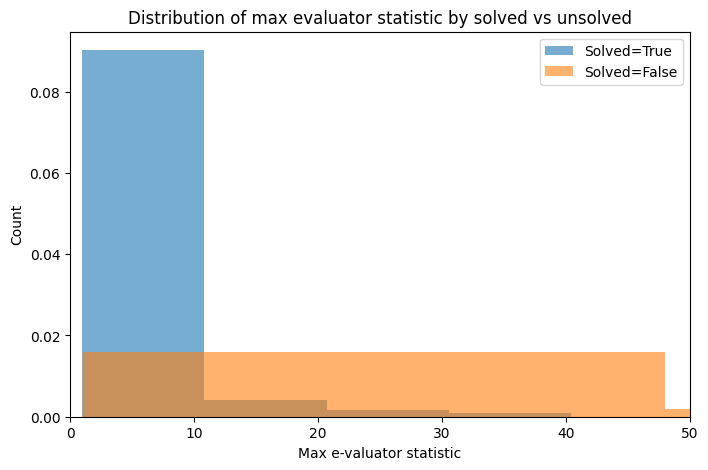

In [17]:
import matplotlib.pyplot as plt

## let's use the empirical version
stat_col = "split_e_val"

grouped = test_df.groupby("uq_problem_idx")
problem_max = grouped[stat_col].max()
problem_solved = grouped["solved"].max()

max_solved = problem_max[problem_solved == 1]
max_unsolved = problem_max[problem_solved == 0]

print("Mean maximum among solved problems:", max_solved.mean())
print("Mean maximum among unsolved problems:", max_unsolved.mean())

plt.figure(figsize=(8,5))
plt.hist(max_solved, bins=40, alpha=0.6, label="Solved=True", density=True)
plt.hist(max_unsolved, bins=40, alpha=0.6, label="Solved=False", density=True)
plt.xlim(0, 50)
plt.xlabel("Max e-valuator statistic")
plt.ylabel("Count")
plt.title("Distribution of max evaluator statistic by solved vs unsolved")
plt.legend()
plt.show()


In [18]:
results_anytime = {}
results_split = {}

## One label per problem
problem_solved = (
    test_df.groupby(ev.problem_col)["solved"]
           .max()
           .astype(int)
)

for a in ev.alphas:
    base = str(a).replace(".", "_")
    col_any = f"reject_anytime_alpha_{base}"
    col_split = f"reject_split_alpha_{base}"

    ## "Ever rejected" for each problem
    reject_any = (
        test_df.groupby(ev.problem_col)[col_any]
               .max()
               .astype(bool)
    )
    reject_split = (
        test_df.groupby(ev.problem_col)[col_split]
               .max()
               .astype(bool)
    )

    ## power: pr(reject|solved == 0)
    ## false alarm rate: pr(reject|solved == 1)
    power_any = reject_any[problem_solved == 0].mean()
    fa_any = reject_any[problem_solved == 1].mean()

    power_split = reject_split[problem_solved == 0].mean()
    fa_split = reject_split[problem_solved == 1].mean()

    results_anytime[a] = (power_any, fa_any)
    results_split[a] = (power_split, fa_split)

print("=== Problem-level Evaluation (anytime) ===")
for a, (power, fa) in results_anytime.items():
    print(f"alpha={a:.3f} | power={power:.4f} | false alarm rate={fa:.4f}")

print("\n=== Problem-level Evaluation (split) ===")
for a, (power, fa) in results_split.items():
    print(f"alpha={a:.3f} | power={power:.4f} | false alarm rate={fa:.4f}")


=== Problem-level Evaluation (anytime) ===
alpha=0.010 | power=0.0825 | false alarm rate=0.0159
alpha=0.050 | power=0.2268 | false alarm rate=0.0397
alpha=0.100 | power=0.4227 | false alarm rate=0.0794
alpha=0.200 | power=0.6495 | false alarm rate=0.1429
alpha=0.300 | power=0.7113 | false alarm rate=0.2222
alpha=0.400 | power=0.7835 | false alarm rate=0.3095
alpha=0.500 | power=0.8351 | false alarm rate=0.4206

=== Problem-level Evaluation (split) ===
alpha=0.010 | power=0.0000 | false alarm rate=0.0000
alpha=0.050 | power=0.0722 | false alarm rate=0.0079
alpha=0.100 | power=0.2990 | false alarm rate=0.0476
alpha=0.200 | power=0.5670 | false alarm rate=0.1190
alpha=0.300 | power=0.6598 | false alarm rate=0.1825
alpha=0.400 | power=0.7010 | false alarm rate=0.2460
alpha=0.500 | power=0.7732 | false alarm rate=0.3492
